In [1]:
import numpy as np # https://numpy.org/ja/
import pandas as pd # https://pandas.pydata.org/
from sklearn.model_selection import train_test_split

In [2]:
# 必要な外部パッケージは、以下の内容を編集しインストールしてください
!pip install keras
!pip install torch
!pip install torchvision
# !pip install tensorflow[and-cuda]

In [23]:
import numpy as np
import pandas as pd
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, stride=2)
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 5 * 5, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

def FFT(img): # https://vigne-cla.com/25-1/
    #フーリエ変換
    fimg = np.fft.fft2(img)
    fimg = np.fft.fftshift(fimg) #低周波成分を中央に寄せる
    #符号を保ったまま対数処理
    real = fimg.real
    real[real>0] = np.log10(real[real>0])
    real[real<0] = -np.log10(-real[real<0])
    imag = fimg.imag
    imag[imag>0] = np.log10(imag[imag>0])
    imag[imag<0] = -np.log10(-imag[imag<0])
    return real, imag

def get_x_data(df, is_fit=True, size=1.0):
    from myLabeling import myLabeling
    from myThinning import MyThinning
    from myOpenClose import MyOpenClose
    target_size = (28, 28)
    resized_images = []
    for row_df in df.itertuples():
        img = row_df.waferMap
        _, img = FFT(img)
        resized_img = resize(img, target_size, anti_aliasing=True)
        resized_images.append(resized_img)
    print(resized_images)
    _X_data = np.array(resized_images)
    X_data = torch.tensor(_X_data, dtype=torch.float)
    X_data = X_data.unsqueeze(1)
    return X_data

def solution(x_test_df, train_df):
    train_df["failureType"].mask(train_df["failureType"] != "Scratch", "Loc", inplace=True)
    le = LabelEncoder()
    X_train = get_x_data(train_df)
    y_train = le.fit_transform(np.array(train_df['failureType']))
    X_test = get_x_data(x_test_df, False)

    transform = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

    # Normalize data
    normalize = transforms.Normalize(mean=[0.5], std=[0.5])
    X_train = normalize(X_train)
    X_test = normalize(X_test)

    # Create DataLoader with data augmentation
    train_dataset = TensorDataset(X_train, torch.tensor(y_train))
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    model = Net()

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adjust the learning rate
    criterion = nn.CrossEntropyLoss()

    epoch = 20  # Increase the number of epochs
    for i in range(1, epoch + 1):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print(f"Epoch {i}/{epoch}, Loss: {loss.item()}")

    # Move model back to CPU before predicting
    model.to("cpu")
    outputs = model(torch.tensor(X_test, dtype=torch.float))
    _, predicted = torch.max(outputs.data, 1)
    y_pred = le.inverse_transform(predicted.numpy())

    return pd.DataFrame({'failureType': y_pred}, index=x_test_df.index)

In [24]:
# %%timeit -r 1 -n 1

# データのインポート
df=pd.read_pickle("../input/LSWMD_25519.pkl")

# テスト用と学習用のデータを作成（テストする際は、random_stateの値などを編集してみてください）
train_df, test_df = train_test_split(df, stratify=df['failureType'], test_size=0.10, random_state=42)

y_test_df = test_df[['failureType']]
x_test_df = test_df.drop(columns=['failureType'])

# solution関数を実行
user_result_df = solution(x_test_df, train_df)

average_accuracy = 0
# ユーザーの提出物のフォーマット確認
if type(y_test_df) == type(user_result_df) and y_test_df.shape == user_result_df.shape:
    # 平均精度の計算
    accuracies = {}
    for failure_type in df['failureType'].unique():
        y_test_df_by_failure_type = y_test_df[y_test_df['failureType'] == failure_type]
        user_result_df_by_failure_type = user_result_df[y_test_df['failureType'] == failure_type]
        matching_rows = (y_test_df_by_failure_type == user_result_df_by_failure_type).all(axis=1).sum()
        accuracies[failure_type] = (matching_rows/(len(y_test_df_by_failure_type)))

    average_accuracy = sum(accuracies.values())/len(accuracies)

print(f"平均精度：{average_accuracy*100:.2f}%")

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 1/20, Loss: 0.1454876959323883
Epoch 2/20, Loss: 0.08709876984357834
Epoch 3/20, Loss: 0.11342538148164749
Epoch 4/20, Loss: 0.17151322960853577
Epoch 5/20, Loss: 0.16938509047031403
Epoch 6/20, Loss: 0.02902154065668583
Epoch 7/20, Loss: 0.007368359714746475
Epoch 8/20, Loss: 0.037175342440605164
Epoch 9/20, Loss: 0.012998677790164948
Epoch 10/20, Loss: 0.0446903370320797
Epoch 11/20, Loss: 0.02290993183851242
Epoch 12/20, Loss: 0.00124385766685009
Epoch 13/20, Loss: 0.020355988293886185
Epoch 14/20, Loss: 0.0036542387679219246
Epoch 15/20, Loss: 0.031957074999809265
Epoch 16/20, Loss: 0.02497803047299385
Epoch 17/20, Loss: 0.003578798146918416
Epoch 18/20, Loss: 0.03257406875491142
Epoch 19/20, Loss: 0.053384337574243546
Epoch 20/20, Loss: 0.002311012474820018


/tmp/ipykernel_287/813001737.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(X_test, dtype=torch.float))


平均精度：14.50%


{'Loc': 0.9665738161559888, 'Edge-Loc': 0.0, 'Center': 0.0, 'Edge-Ring': 0.0, 'Scratch': 0.19327731092436976, 'Random': 0.0, 'Near-full': 0.0, 'Donut': 0.0}


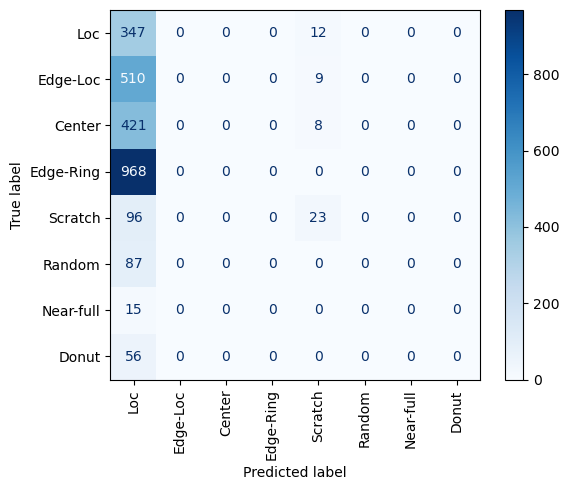

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(accuracies)
labels = df['failureType'].unique()
cm = confusion_matrix(y_pred=user_result_df['failureType'], y_true=y_test_df['failureType'], labels=labels)
# display_labels: 集計して表示するラベル。
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)

cmp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')


In [6]:
#
# 誤分類したものを閲覧する。
#
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt

# 画像の表示関数
def image_show(target_df, y_test_df, x_test_df, user_result_df, x=0): 
    ori_image = x_test_df.waferMap[x]
    true_label = y_test_df.failureType[x]
    result_label = user_result_df.failureType[x]
    print('true label  :', true_label)
    print('result label:', result_label)
    plt.imshow(ori_image)
    plt.show()
    return x

# failureType 選択関数
def select_type(failureType='Loc'): 
    drop_indexes = []
    for index in range(len(user_result_df)):
        true_df = y_test_df.iloc[index]
        result_df = user_result_df.iloc[index]
        if true_df.failureType != failureType:
            drop_indexes.append(true_df.name)
            continue
        if true_df.failureType == result_df.failureType:
            drop_indexes.append(true_df.name)
    filterd_df = x_test_df.drop(index=drop_indexes)
    num_widget = widgets.IntSlider(
        value=0,
        min=0,
        max=len(filterd_df.waferMap) - 1
    )
    interact(image_show,
        x=num_widget,
        target_df=fixed(x_test_df.drop(index=drop_indexes).reset_index()),
        y_test_df=fixed(y_test_df.drop(index=drop_indexes).reset_index()),
        x_test_df=fixed(x_test_df.drop(index=drop_indexes).reset_index()),
        user_result_df=fixed(user_result_df.drop(index=drop_indexes).reset_index()),
    );

labels = y_test_df.failureType.unique() # ラベル取得
interact(select_type, failureType=labels); # failureType選択

interactive(children=(Dropdown(description='failureType', index=2, options=('Edge-Ring', 'Edge-Loc', 'Loc', 'R…